In [1]:
# Importo librerias necesarias
import warnings
warnings.filterwarnings("ignore")
import numpy as np # librería para poder usar arreglos
import pandas as pd # librería para poder usad DataFrames (tablas)
import plotly.express as px
import matplotlib.pyplot as plt # to plot
import seaborn as sns # to plot
import sklearn # librería para poder usar modelos de machine learning

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.decomposition as sk # to compute PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


In [12]:
def get_data():
    """
    Funcion para obtener los datos del archivo covid.csv
    """

    dataSet = pd.read_csv("covid.csv", header=0)
    dataSet.set_index('date', inplace=True)
    dataSet.index = pd.to_datetime(dataSet.index,format='%d/%m/%y',errors='ignore')

    return dataSet

def infoData(dataSet):
    """
    Funcion para obtener datos generales
    """

    print(dataSet.head(10))
    print("")
    print(dataSet.info())
    print("")
    print(dataSet.isnull().sum())
    print("")

In [25]:
data = get_data()
infoData(data)


            AGUASCALIENTES  BAJA CALIFORNIA  BAJA CALIFORNIA SUR  CAMPECHE  \
date                                                                         
2020-02-26               0                0                    0         0   
2020-02-27               0                0                    0         0   
2020-02-28               0                0                    0         0   
2020-02-29               0                0                    0         0   
2020-03-01               0                0                    0         0   
2020-03-02               0                0                    0         0   
2020-03-03               0                0                    0         0   
2020-03-04               0                0                    0         0   
2020-03-05               0                0                    0         0   
2020-03-06               0                0                    0         0   

            CHIAPAS  CHIHUAHUA  DISTRITO FEDERAL  COAHUILA  COL

In [ ]:
def preprocess_data(dataSet):
    """
    Funcion para el preprocesamiento de datos
    """

    local_dataSet = dataSet.dropna()
    columns_list = dataSet.columns.tolist()
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(local_dataSet)
    new_dataSet = min_max_scaler.transform(local_dataSet)

    new_dataSet = pd.DataFrame(np.round(new_dataSet,4), columns=columns_list)
    new_dataSet.index = local_dataSet.index

    return new_dataSet

def getCorr(dataSet):
    """
    Funcion para obtener la matriz de correlacion
    """

    print(dataSet.head(1215))
    print("")
    print(dataSet.describe())
    print("")

    plt.figure(figsize=(10, 8))
    sns.heatmap(dataSet.corr(), annot=True, cmap='coolwarm', fmt=".2f") # Calculate correlation on the DataFrame itself
    plt.title('Matriz de Correlación', fontweight='bold')
    plt.show()

            AGUASCALIENTES  BAJA CALIFORNIA  BAJA CALIFORNIA SUR  CAMPECHE  \
date                                                                         
2020-02-26          0.0000           0.0000               0.0000    0.0000   
2020-02-27          0.0000           0.0000               0.0000    0.0000   
2020-02-28          0.0000           0.0000               0.0000    0.0000   
2020-02-29          0.0000           0.0000               0.0000    0.0000   
2020-03-01          0.0000           0.0000               0.0000    0.0000   
...                    ...              ...                  ...       ...   
2023-06-20          0.0020           0.0088               0.0009    0.0073   
2023-06-21          0.0013           0.0078               0.0028    0.0049   
2023-06-22          0.0033           0.0062               0.0009    0.0000   
2023-06-23          0.0000           0.0020               0.0014    0.0170   
2023-06-24          0.0000           0.0000               0.0000

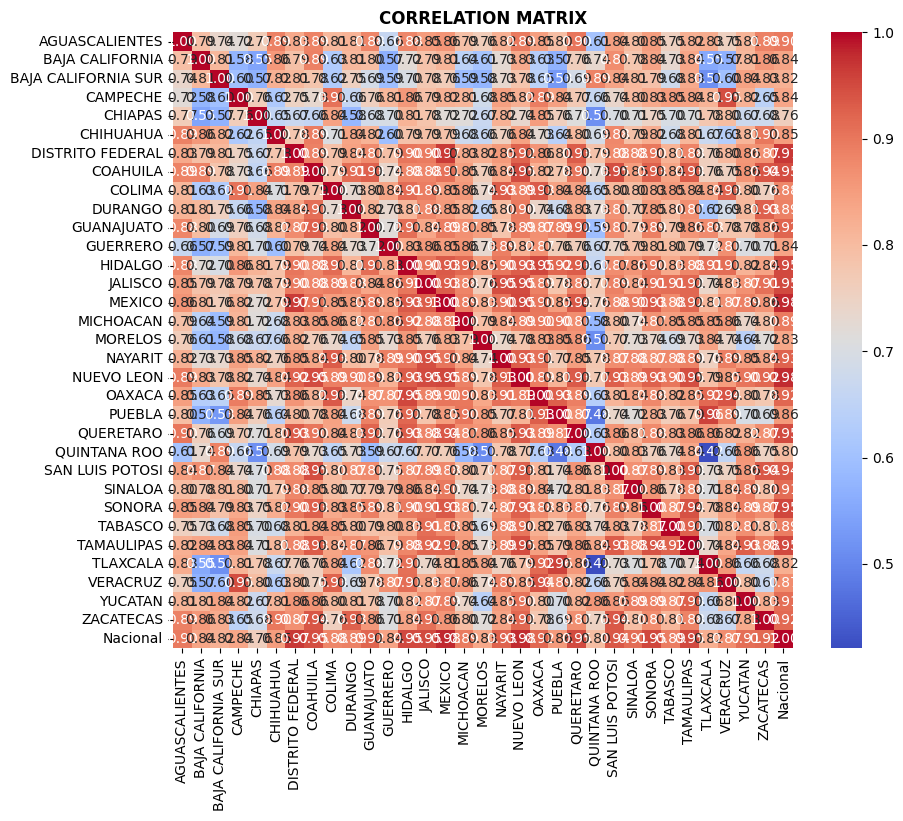

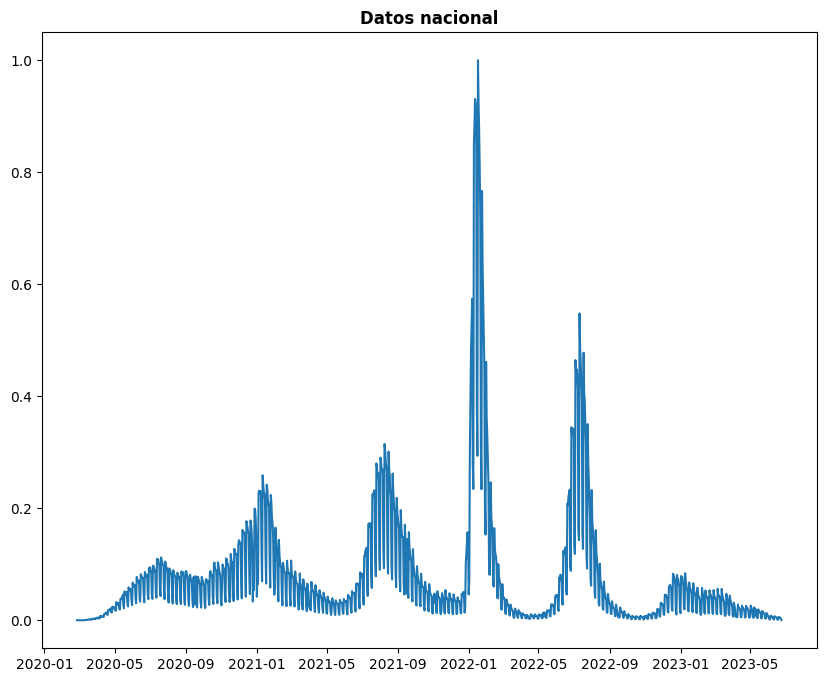

In [26]:
preprocessData = preprocess_data(data)
getCorr(preprocessData)

plt.figure(figsize=(10, 8))
plt.plot(preprocessData['Nacional'])
plt.title('Datos nacional', fontweight='bold')
plt.show()

In [27]:
def pca_Transformation(dataSet):
    features = dataSet
    features = features.drop(['Nacional'], axis=1)

    # principal components analysis
    pca = sk.PCA(n_components=3)
    principalComponents = pca.fit_transform(features)
    principalComp = pd.DataFrame(data = principalComponents,
                                 columns = ['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3'])
    principalComp.set_index(dataSet.index,inplace = True, drop=True)
    principalComp['Nacional'] = dataSet['Nacional']
    cols = principalComp.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    principalComp = principalComp[cols]

    print("==========================================================")
    print("                 PCA ANALYSIS")
    print("----------------------------------------------------------")
    print(principalComp)
    print("\n")

    varRatio = (pca.explained_variance_ratio_)*100
    data = {'P. Comp. 1':varRatio[0],'P. Comp. 2':varRatio[1],'P. Comp. 3':varRatio[2]}
    dfVar = pd.DataFrame(data, index=['Exp Var Ratio %'])
    print(dfVar)
    print("\n")

    return principalComp

In [28]:
pcaData = pca_Transformation(preprocessData)
pcaData.head(1215)

                 PCA ANALYSIS
----------------------------------------------------------
            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2023-06-20    0.0055   -0.385418   -0.023980   -0.031617
2023-06-21    0.0050   -0.389817   -0.025970   -0.026036
2023-06-22    0.0048   -0.394643   -0.029628   -0.022447
2023-06-23    0.0026   -0.401546   -0.021571   -0.028535
2023-06-24    0.0002   -0.419864   -0.024882   -0.014331

[1215 rows x 4 columns]


                 P. Comp. 1  P. Comp. 2  P. Comp. 3
Exp Var Ratio %   81.101835    5.824434    3.614026




,Nacional,P. Comp. 1,P. Comp. 2,P. Comp. 3
date,,,,
2020-02-26,0.0000,-0.420984,-0.025472,-0.013954
2020-02-27,0.0000,-0.420786,-0.025421,-0.013903
2020-02-28,0.0000,-0.420896,-0.025544,-0.013894
2020-02-29,0.0000,-0.420792,-0.025320,-0.014072
2020-03-01,0.0000,-0.420784,-0.025356,-0.013891
...,...,...,...,...
2023-06-20,0.0055,-0.385418,-0.023980,-0.031617
2023-06-21,0.0050,-0.389817,-0.025970,-0.026036
2023-06-22,0.0048,-0.394643,-0.029628,-0.022447


In [29]:
train_data, test_data = train_test_split(pcaData, test_size=0.25, shuffle=False)
print(train_data.head(1215))
print("")
print(len(train_data))
print("")
print(test_data.head(1215))
print("")
print(len(test_data))

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2022-08-20    0.0210   -0.287385    0.002451    0.002460
2022-08-21    0.0187   -0.293690    0.000125    0.009103
2022-08-22    0.0691   -0.015549    0.005202    0.060701
2022-08-23    0.0507   -0.102404    0.010890    0.055541
2022-08-24    0.0462   -0.132828    0.019228    0.046232

[911 rows x 4 columns]

911

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2022-08-25    0.0404   -0.171591    0.015264    0.020806
2022-08-26    0.0362   -0.204175    0.005791    0.015538
2

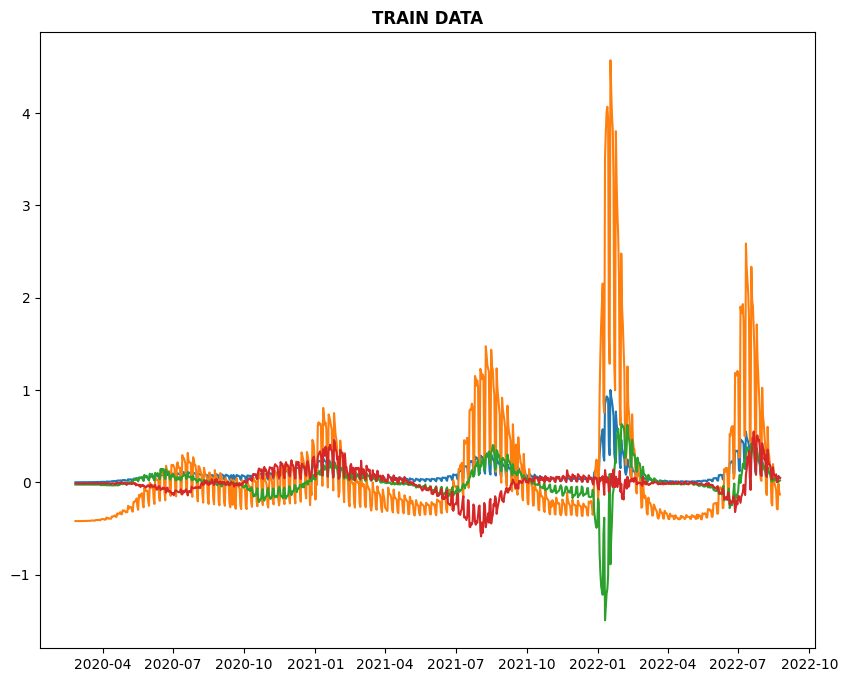

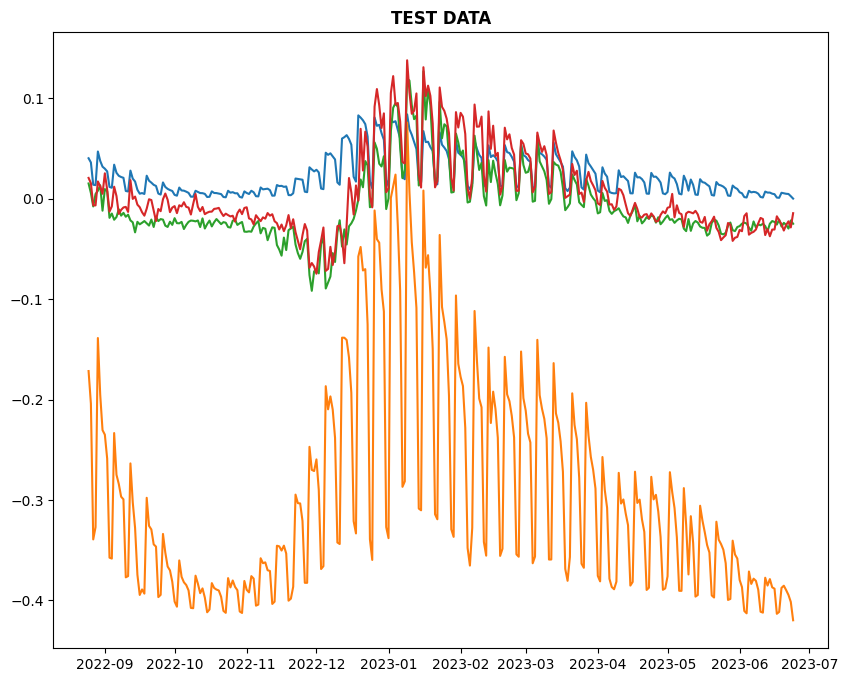

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(train_data)
plt.title('TRAIN DATA', fontweight='bold')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(test_data)
plt.title('TEST DATA', fontweight='bold')
plt.show()

Modelado del PCA

In [ ]:
# Decision Tree Regressor
